# EDS 220 Fall 2022
# Data Regridding

Let's get some practice working with interpolation and data regridding! We'll be working with the same SST datasets used in other notebooks, just to make things easier.

__NOTE: the selection of the correct Python kernel is important!__

This notebook requires the use of Cartopy later on - on Taylor, the "carto" kernel should allow access to this and all other necessary packages.

Import packages first:

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy
from scipy import interpolate
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature

### 1) Read in data

To demonstrate the process of converting two-dimensional data to a common grid, we'll use two gridded climate data products:

* The [NOAA Extended Reconstructed Sea Surface Temperature version 5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) (ERSSTv5)
* The [Global Precipitation Climatology Product](https://psl.noaa.gov/data/gridded/data.gpcp.html) (GPCP)

Both of these data sets have relatively low spatial resolution: roughly 2 degrees on a side in lat and lon. This makes them quick to load over OpeNDAP. But the locations of the data points are not the same, meaning that to directly compare we need to do our regridding exercise!

First, load the data using the remote OpeNDAP URLs:

In [2]:
# location of ERSSTv5 data
ersst_url="https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"

# open dataset using remote URL
ersst=xr.open_dataset(ersst_url,drop_variables="time_bnds")

# display dataset to see what it looks like
ersst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2025)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-09-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-10-04
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
# Location of precipitation dataset
gpcp_url="https://psl.noaa.gov/thredds/dodsC/Datasets/gpcp/precip.mon.mean.nc"

# open dataset with remote URL
gpcp=xr.open_dataset(gpcp_url,drop_variables="time_bnds")

# display dataset to see what it looks like
gpcp

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2, time: 525)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-09-01
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (lat, nv) float32 ...
    lon_bnds  (lon, nv) float32 ...
    precip    (time, lat, lon) float32 ...
Attributes: (12/19)
    Conventions:                     CF-1.0
    curator:                         Dr. Jian-Jian Wang\nESSIC, University of...
    citation:                        Adler, R.F., G.J. Huffman, A. Chang, R. ...
    title:                           GPCP Version 2.3 Combined Precipitation ...
    platform:                        NOAA POES (Polar Orbiting Environmental ...
    source_obs:                      CDR RSS SSMI/SSMIS Tbs over ocean \nCDR ...
    ...                              ...
    source_documentation:            https://www.ncdc.noaa.gov/cdr/atmospheri...
    NCO:                             4.6.9
    history:                         Generated at NOAA/ESRL PSD Sep 9 2016 ba...
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    data_comment:                    Interim data covers 2022/08 through latest.
    DODS_EXTRA.Unlimited_Dimension:  time

To get a visual sense of how the data products are laid out spatially, we can create plots using Matplotlib's `pcolor`. If we wanted to create a production-quality plot, using a map projection with Cartopy would be necessary, but here we're just looking for a quick overview:

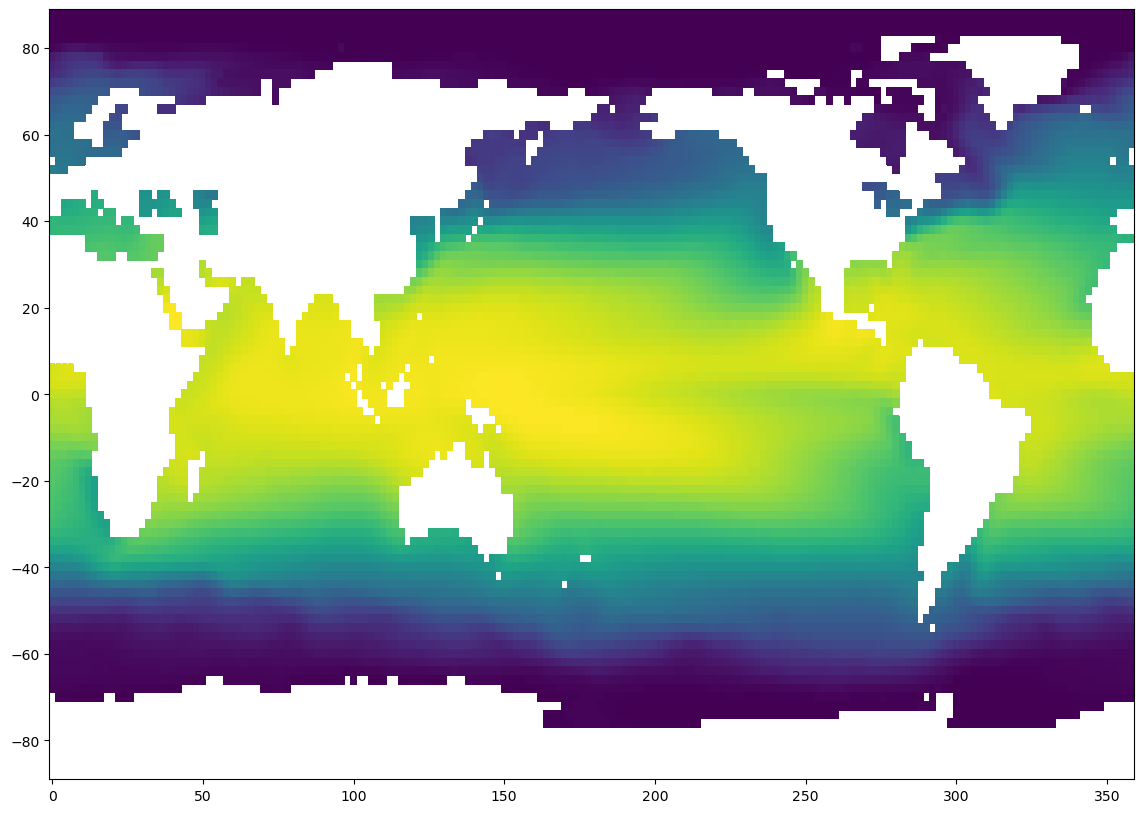

In [4]:
# Take time average of ERSST data
ersst_timeavg=ersst['sst'].mean(dim='time')

# Create a blank figure
plt.figure(figsize=(14,10))
# Plot ERSST time average
plt.pcolor(ersst['lon'],ersst['lat'],ersst_timeavg)

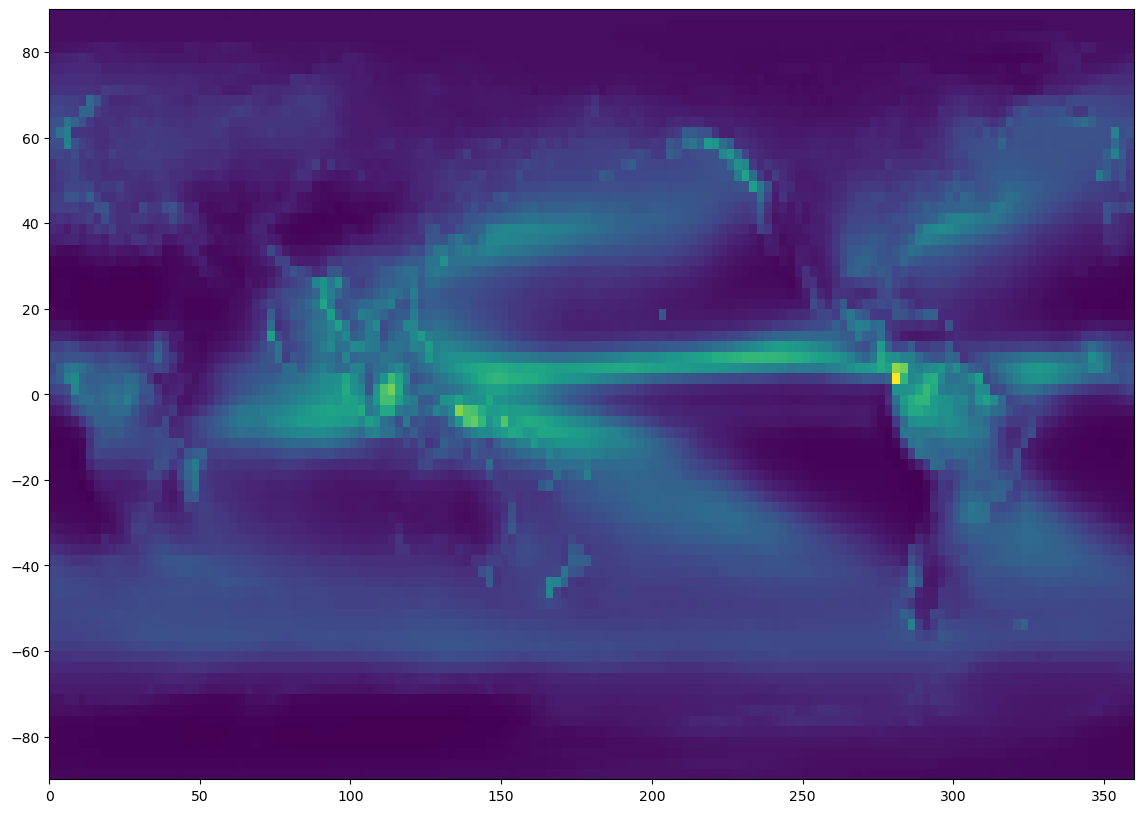

In [5]:
# Take time average of GPCP data
gpcp_timeavg=gpcp['precip'].mean(dim='time')

# Create a blank figure
plt.figure(figsize=(14,10))
# Plot GPCP time average
plt.pcolor(gpcp['lon'],gpcp['lat'],gpcp_timeavg)

### 2) Interpolate to a common grid: xarray built-in functionality

It should be clear that there are differences between these datasets: they're entirely different variables, with different spatial coverages, and slightly different resolutions. Now let's put them on a common grid!

The first method we'll use to do this is the built-in `interp` capacity that is held by xarray objects:

[https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html)

This is a wrapper around the interpolation functions within the `scipy` package.

In [6]:
# Interpolate GPCP to SST grid
gpcp_int = gpcp_timeavg.interp(lat=ersst.lat, lon=ersst.lon)

In [7]:
# Display header info for interpolated GPCP
gpcp_int

<xarray.DataArray 'precip' (lat: 89, lon: 180)>
array([[       nan, 0.51145107, 0.51474226, ..., 0.5036635 , 0.50674427,
        0.5083106 ],
       [       nan, 0.504552  , 0.50848204, ..., 0.5004041 , 0.50356025,
        0.50435674],
       [       nan, 0.53476566, 0.53650177, ..., 0.5292714 , 0.52724975,
        0.52720016],
       ...,
       [       nan, 0.17410395, 0.1703869 , ..., 0.19479217, 0.19536977,
        0.19019984],
       [       nan, 0.20101255, 0.20022312, ..., 0.20747878, 0.21176721,
        0.20833342],
       [       nan, 0.2734403 , 0.27000222, ..., 0.279839  , 0.28885692,
        0.28820693]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

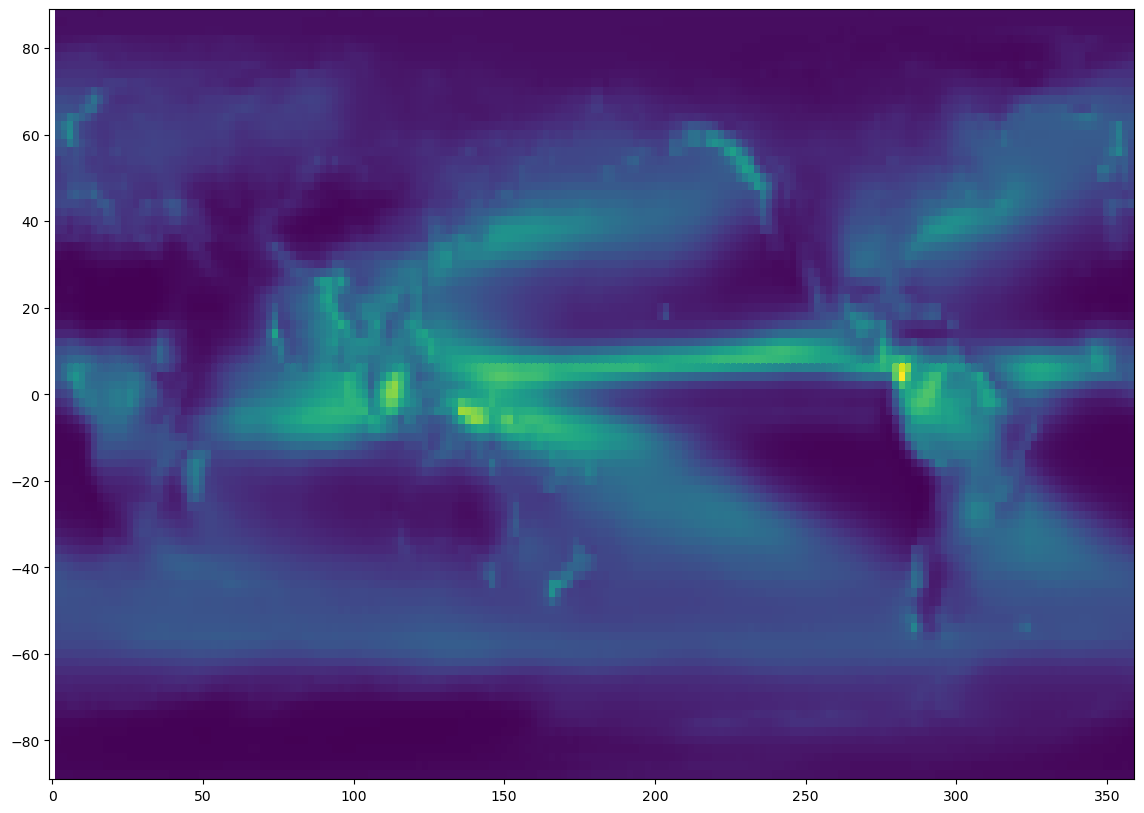

In [8]:
# Create a blank figure
plt.figure(figsize=(14,10))
# Plot interpolated GPCP
plt.pcolor(gpcp_int['lon'],gpcp_int['lat'],gpcp_int)

### 3) Interpolate to a common grid: Scipy

It's also useful to know how the Scipy package itself handles interpolation, since sometimes data may be read in using formats other than xarray. To do this, we can simply call the Scipy `interpolate` package (imported at the beginning of this notebook) directly.

Here I'll demonstrate an example using the `interp2d` package within interpolate:

[https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html)

In [16]:
# Create interpolation function using Scipy interp2d with input data
precip_intfn = interpolate.interp2d(gpcp.lon,gpcp.lat,gpcp_timeavg, kind='linear')

Note that the lat and lon values input to `interpolate.interp2d` are the NATIVE (original) lat and lon, NOT the ones we would eventually like to interpolate onto. . That is because the code block above generates an object (`precip_intfn`) which is a Scipy interpolation _function_, which can be evaluated on an arbitrary set of __new__ lon and lat values.

Before performing the interpolation, let's examine the lat and lon coordinates onto which we'd like to perform it:

In [21]:
# Target longitude array
ersst.lon

<xarray.DataArray 'lon' (lon: 180)>
array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
        48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
        72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,
        96.,  98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
       120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140., 142.,
       144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
       168., 170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
       192., 194., 196., 198., 200., 202., 204., 206., 208., 210., 212., 214.,
       216., 218., 220., 222., 224., 226., 228., 230., 232., 234., 236., 238.,
       240., 242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
       288., 290., 292., 294., 296., 298., 300., 302., 304., 306., 308., 310.,
       312., 314., 316., 318., 320., 322., 324., 326., 328., 330., 332., 334.,
       336., 338., 340., 342., 344., 346., 348., 350., 352., 354., 356., 358.],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    units:               degrees_east
    long_name:           Longitude
    actual_range:        [  0. 358.]
    standard_name:       longitude
    axis:                X
    coordinate_defines:  center

In [22]:
# Target latitude array
ersst.lat

<xarray.DataArray 'lat' (lat: 89)>
array([ 88.,  86.,  84.,  82.,  80.,  78.,  76.,  74.,  72.,  70.,  68.,  66.,
        64.,  62.,  60.,  58.,  56.,  54.,  52.,  50.,  48.,  46.,  44.,  42.,
        40.,  38.,  36.,  34.,  32.,  30.,  28.,  26.,  24.,  22.,  20.,  18.,
        16.,  14.,  12.,  10.,   8.,   6.,   4.,   2.,   0.,  -2.,  -4.,  -6.,
        -8., -10., -12., -14., -16., -18., -20., -22., -24., -26., -28., -30.,
       -32., -34., -36., -38., -40., -42., -44., -46., -48., -50., -52., -54.,
       -56., -58., -60., -62., -64., -66., -68., -70., -72., -74., -76., -78.,
       -80., -82., -84., -86., -88.], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
Attributes:
    units:               degrees_north
    long_name:           Latitude
    actual_range:        [ 88. -88.]
    standard_name:       latitude
    axis:                Y
    coordinate_defines:  center

These look reasonable, but there is one important thing to notice - the _ordering_ of the latitude points is reversed in the ERSST dataset relative to GPCP. If we do not fix this, it will result in an interpolated precipitation field with an "upside down" appearance (yes, I tried this).

Fortunately, the fix is relatively easy: we just need to create a sorted version of the latitude array before performing the interpolation.

In [26]:
# Sort latitude array
ersst_lat_sort = np.sort(ersst.lat)

# Display sorted latitudes
ersst_lat_sort

array([-88., -86., -84., -82., -80., -78., -76., -74., -72., -70., -68.,
       -66., -64., -62., -60., -58., -56., -54., -52., -50., -48., -46.,
       -44., -42., -40., -38., -36., -34., -32., -30., -28., -26., -24.,
       -22., -20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,
         0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.], dtype=float32)

In [27]:
# Evaluate interpolation function on new grid: i.e. perform the interpolation
sc_precip_int = precip_intfn(ersst.lon,ersst_lat_sort)

To make it more obvious how the raw vs. interpolated values compare, let's make a real map of both using Cartopy. 

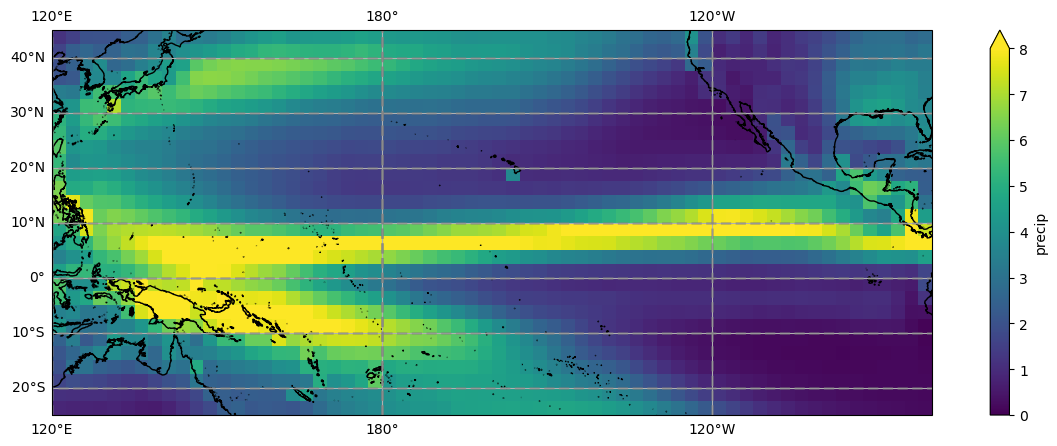

In [32]:
# Create new Plate-Carree projection
proj = ccrs.PlateCarree(central_longitude=180)
# Make blank figure 
fig = plt.figure(figsize=(15, 5))
# Create axes using map projection
ax = plt.axes(projection=proj)
# Plot data onto projected axis
gpcp_timeavg.plot(x='lon', y='lat',transform=ccrs.PlateCarree(),vmin=0,vmax=8)

ax.gridlines()
ax.set_extent([120, 280, -25, 45], crs=ccrs.PlateCarree())
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.show()

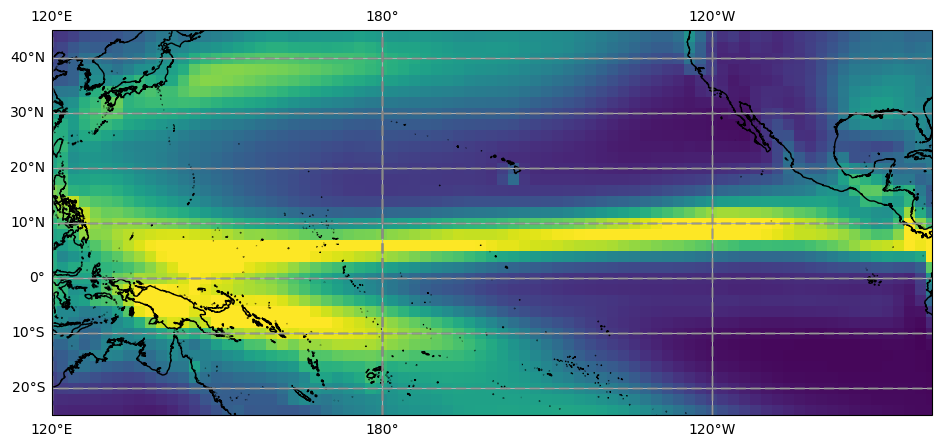

In [33]:
# Create new Plate-Carree projection
proj = ccrs.PlateCarree(central_longitude=180)
# Make blank figure 
fig = plt.figure(figsize=(15, 5))
# Create axes using map projection
ax = plt.axes(projection=proj)
# Plot data onto projected axis
plt.pcolor(ersst.lon,ersst_lat_sort,sc_precip_int,transform=ccrs.PlateCarree(),vmin=0,vmax=8)

ax.gridlines()
ax.set_extent([120, 280, -25, 45], crs=ccrs.PlateCarree())
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.show()

Since the input and output grids are not _that_ different from one another, the differences in the interpolated map is somewhat subtle. However, you can see differences in the grid boxes between the upper and lower panels, as well as some shifts in the appearance of the major precipitation features. If your input and output grids differ more from one another, you can expect even larger effects!